In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-046eebf7-cbda-fc51-5f07-9cdbeefdeb48)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm
!cp /content/drive/MyDrive/ENS/models_mae.py /content #import model arch
!cp /content/drive/MyDrive/ENS/scheduler_pl.py /content/
!cp /content/drive/MyDrive/ENS/visualize.py /content/
#!cp /content/drive/MyDrive/ENS/Baby_mae_8M/checkpoint-99.pth /content/
!cp /content/drive/MyDrive/ENS/training_utils.py /content/

from training_utils import *


from collections import defaultdict

import torch
import torchvision.datasets as datasets
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import numpy as np
import pickle
from tqdm import tqdm
import torch.nn.functional as F


from visualize import to_print,visualize_mae_3pictures,visualize_neighbors
from models_mae import MaskedAutoencoderViT

from functools import partial
from torch import nn



import os 
#repo = '/content/drive/MyDrive/Imagenet_indiv/'



# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# DeiT: https://github.com/facebookresearch/deit
# BEiT: https://github.com/microsoft/unilm/tree/master/beit
# --------------------------------------------------------
import datetime
import json
from  scheduler_pl import LinearWarmupCosineAnnealingLR

inet_mean = [0.485, 0.456, 0.406]
inet_std = [0.229, 0.224, 0.225]
import time
import numpy as np
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from functools import partial
import torch.nn as nn
import timm.optim.optim_factory as optim_factory
from models_mae import MaskedAutoencoderViT

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.1 MB/s 


In [ ]:
import os 
base_repo = '/content/Imagenet/'
repo = '/content/Imagenet/train/'
repo_val = '/content/Imagenet/val/'
if not os.path.exists(base_repo):
  os.mkdir(base_repo)
  os.mkdir(repo)
  os.mkdir(repo_val)

data_path = '/content/drive/MyDrive/ENS/Imagenet/'

In [ ]:
#The Imagenet 64 x 64 dataset is downloaded in the form of large batches of several tens of thousands of images. 
#As we cannot use them as they are, we propose to reseparate the images, and to save them directly as tensors to facilitate their reading during training.

val = True
counter = 0


for j in range(10):
  x = pickle.load(open(data_path + 'train_data_batch_' + str(1+j),'rb'))
  n = len(x['data'])
  imgs = torch.tensor(x['data'],dtype=torch.float32).to('cuda').reshape(n,3,64,64) #add to.('cuda') will be faster
  labels = torch.tensor(x['labels'],dtype=torch.uint8).to('cuda')

  for i in tqdm(range(len(imgs))):
    f_name = repo + str(counter)+".pt"
    img = imgs[i].clone().cpu()/255.

    #img = T_n(img)
    #label = labels[i]
    torch.save(img,f_name) #saving as list list,label double the space needed
    counter+=1

if val:
  x = pickle.load(open(data_path + 'val_data','rb'))
  n = len(x['data'])
  imgs = torch.tensor(x['data'],dtype=torch.float32).to('cuda').reshape(n,3,64,64) #add to.('cuda') will be faster

  val_counter = 0
  for i in tqdm(range(len(imgs))):
    f_name = repo_val + str(val_counter)+".pt"
    img = imgs[i].clone().cpu()/255.

    #img = T_n(img)
    #label = labels[i]
    torch.save(img,f_name) #Saving as list list,label (double the space needed)
    val_counter+=1 #50000


100%|██████████| 50000/50000 [00:21<00:00, 2339.96it/s]


In [ ]:
val_counter = 50000
counter = 1281167

On 64 x 64 we find :
ycbcrmean = [0.3439,0.4769,0.5153]
instead of standard conversion : [0.3441, 0.4757, 0.5183] (probably due to resolution or not taking val dataset into account)

In [ ]:
#counter = 1281167 #len(counter) = dataset_sizze
#length_bis = 1000
img_list_inet = [repo + str(i)+".pt" for i in range(counter)]
img_list_inet_val = [repo_val + str(i)+".pt" for i in range(val_counter)]




inet_mean = [0.485, 0.456, 0.406] #will become automatically ycbcr meanb (see data_bis)
inet_std = [0.229, 0.224, 0.225]

  
Augmentation =  transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
            transforms.RandomHorizontalFlip(p=0.5)])

class DATA_bis(Dataset):
    def __init__(self, img_list, transform = None, mean = None, std = None, ycbcr_converter=None):
        self.img_list = img_list
        self.transform = transform
        self.ycbcr_converter = ycbcr_converter
        self.mean = mean
        self.std = std
        self.normalize = None
        if self.mean is not None and self.std is not None:
          if self.ycbcr_converter is not None:
            self.mean = ycbcr_converter.to_ycbcr_vec(self.mean)
            self.std = ycbcr_converter.to_ycbcr_vec(self.std)
          self.normalize = transforms.Normalize(mean=self.mean,
                         std=self.std)
        

        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx,t = True):
        img_path = self.img_list[idx]
        img = torch.load(img_path)
        
        #img = img.unsqueeze(diml=0) #add a dimension (same as img = img[None,:]) #not necssary as dataloder will create batch dimension
        if t:
          if self.transform is not None: #data augmentation
            img = self.transform(img)
        if self.ycbcr_converter is not None: #to ycbcr if needed
          img = self.ycbcr_converter.to_ycbcr(img)
        if self.normalize is not None:
          img = self.normalize(img)
        #img = torch.einsum('hwc->chw', img) #switch channel position

        return img



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
inet_train = DATA_bis(img_list_inet,transform = Augmentation, mean = inet_mean, std = inet_std)

inet_train_loader = torch.utils.data.DataLoader(inet_train,
                         batch_size=512,
                         num_workers=4,
                         shuffle=True)

inet_val = DATA_bis(img_list_inet_val,transform = None, mean = inet_mean, std = inet_std)

inet_val_loader = torch.utils.data.DataLoader(inet_val,
                         batch_size=10,
                         num_workers=4,
                         shuffle=True)

In [ ]:
batch = next(iter(inet_val_loader))


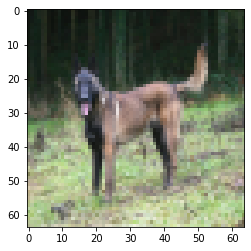

In [ ]:
#Tests
#load image

#Plot a image
img = inet_val.__getitem__(5,t=False)

#IF NO YCBCR
#img = torch.einsum('chw->hwc',img)
#plt.imshow(torch.clip((img*torch.Tensor(inet_std) + torch.Tensor(inet_mean)) * 255, 0, 255).int())

#IF YCBCR

img = (img.T*torch.tensor(inet_std) + torch.tensor(inet_mean)).T
img = torch.einsum('chw->hwc',img)
plt.imshow((img*255).int())

In [ ]:
def evaluate(model,loader,mask_ratio):
    loss_rgb_total = 0
    n_batch = len(loader)
    for samples in tqdm(loader):
      with torch.no_grad():

        # we use a per iteration (instead of per epoch) lr scheduler
        #if data_iter_step % accum_iter == 0: #0%1 !=0...
        #adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, lr,min_lr,epochs,warmup_epochs) #defaault schedule
        samples = samples.to('cuda',non_blocking=True)

        with torch.cuda.amp.autocast():
            loss, pred, mask = model(samples, mask_ratio=mask_ratio)

        loss_value = loss.item()

        torch.cuda.synchronize()

        loss_rgb_total+=loss.item()
        if not math.isfinite(loss_value):
            print("Loss is {} during evaluation, stopping training".format(loss_value))
            sys.exit(1)
    loss_rgb_total = loss_rgb_total/n_batch

    return(loss_rgb_total)

In [ ]:
import math
import sys
from typing import Iterable

import torch



def train_one_epoch(model,
                    data_loader,
                    optimizer,
                    device,
                    epoch,
                    loss_scaler,
                    log_writer,
                    lr,
                    min_lr,
                    epochs,
                    warmup_epochs,
                    accum_iter,
                    mask_ratio,scheduler,
                    ref):
    model.train(True)
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 20

    scheduler.step(epoch)
    lr = optimizer.param_groups[0]["lr"]
    
    optimizer.zero_grad()

    if log_writer is not None:
        print('log_dir: {}'.format(log_writer.log_dir))

    for data_iter_step, samples in enumerate(metric_logger.log_every(data_loader, print_freq, header)):

        # We use a per iteration (instead of per epoch) lr scheduler
        #if data_iter_step % accum_iter == 0: #0%1 !=0...
        #adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, lr,min_lr,epochs,warmup_epochs) #defaault schedule

        samples = samples.to(device, non_blocking=True)

        with torch.cuda.amp.autocast():
            loss, _, _ = model(samples, mask_ratio=mask_ratio)

        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        loss /= accum_iter
        loss_scaler(loss, optimizer, parameters=model.parameters(),
                    update_grad=(data_iter_step + 1) % accum_iter == 0)
        if (data_iter_step + 1) % accum_iter == 0:
            optimizer.zero_grad()

        torch.cuda.synchronize()

        metric_logger.update(loss=loss_value)
        #optimizer.param_groups[0]["lr"] = max(optimizer.param_groups[0]["lr"], min_lr)
        

        metric_logger.update(lr=lr)

        loss_value_reduce = all_reduce_mean(loss_value)
        '''if log_writer is not None and (data_iter_step + 1) % accum_iter == 0:
            """ We use epoch_1000x as the x-axis in tensorboard.
            This calibrates different curves when batch size changes.
            """
            epoch_1000x = int((data_iter_step / len(data_loader) + epoch) * 1000)
            log_writer.add_scalar('train_loss', loss_value_reduce, epoch_1000x)
            log_writer.add_scalar('lr', lr, epoch_1000x)'''
        
    
    if epoch % 5 ==0:
      with torch.no_grad():
        loss, ys, masks = model(ref, mask_ratio=mask_ratio)
        visualize_mae_3pictures(ref[0],ys[0],masks[0],img_size=64,patch_size=8,std=inet_std,mean=inet_mean)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [ ]:


import datetime
import json
from  scheduler_pl import LinearWarmupCosineAnnealingLR


import time
import numpy as np
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from functools import partial
import torch.nn as nn
import timm.optim.optim_factory as optim_factory
from models_mae import MaskedAutoencoderViT

n_heads = 16
patch_size = 8
img_size = 64
num_patch = int((img_size/patch_size)**2)
model = MaskedAutoencoderViT(
        img_size=img_size,patch_size=patch_size, embed_dim=240, depth=10, num_heads=12,
        decoder_embed_dim=160, decoder_depth=6, decoder_num_heads=n_heads,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params


8915872

In [ ]:
model = model.to('cuda')

#data-----------


inet_train = DATA_bis(img_list_inet,transform = Augmentation, mean = inet_mean, std = inet_std)

inet_train_loader = torch.utils.data.DataLoader(inet_train,
                         batch_size=512,
                         num_workers=4,
                         shuffle=True)

inet_val = DATA_bis(img_list_inet_val,transform = None, mean = inet_mean, std = inet_std)

inet_val_loader = torch.utils.data.DataLoader(inet_val,
                         batch_size=128,
                         num_workers=4,
                         shuffle=True)

img_test = inet_train.__getitem__(0,t=False).unsqueeze(dim=0).to('cuda')
#----------------

epochs = 100
accum_iter = 1
norm_pix_loss = False
weight_decay = 0.05
lr = None
blr =  1.5e-4 #try smllr ?
min_lr = 1.5e-7
warmup_epochs = 3 #try smaller ?

log_dir = '/content/drive/MyDrive/ENS/Baby_mae' #'./output_dir'
output_dir = '/content/drive/MyDrive/ENS/Baby_mae' #'./output_dir'
device = 'cuda'
seed = 0
resume = ''
start_epoch = 0 # ??
num_workers = 4
mask_ratio = 0.75
world_size = 1
local_rank = -1


global_rank = get_rank()
# distributed training parameters

#parser.add_argument('--dist_on_itp', action='store_true')
#parser.add_argument('--dist_url', default='env://',
                    #help='url used to set up distributed training')


#print('job dir: {}'.format(os.path.dirname(os.path.realpath(__file__))))
#print("{}".format(args).replace(', ', ',\n'))

device = torch.device(device)

# fix the seed for reproducibility
seed = seed + get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

# simple augmentation

sampler_train = torch.utils.data.RandomSampler(inet_train)

if global_rank == 0 and log_dir is not None:
    os.makedirs(log_dir, exist_ok=True)
    log_writer = SummaryWriter(log_dir=log_dir)
else:
    log_writer = None


# define the model


model_without_ddp = model
print("Model = %s" % str(model_without_ddp))

eff_batch_size = 1024 * accum_iter * get_world_size()

if lr is None:  # only base_lr is specified
    lr = blr * eff_batch_size / 256

print("base lr: %.2e" % (lr * 256 / eff_batch_size))
print("actual lr: %.2e" % lr)

print("accumulate grad iterations: %d" % accum_iter)
print("effective batch size: %d" % eff_batch_size)



# following timm: set wd as 0 for bias and norm layers
param_groups = optim_factory.add_weight_decay(model_without_ddp, weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.95))
scheduler = LinearWarmupCosineAnnealingLR(optimizer,warmup_epochs,epochs,min_lr)

print(optimizer)
loss_scaler = NativeScalerWithGradNormCount()

Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 240, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((240,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=240, out_features=720, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=240, out_features=240, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((240,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=240, out_features=960, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=960, out_features=240, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((240,), eps=1e-06, elementwise_affine=True)
   

In [ ]:
!cp /content/drive/MyDrive/ENS/Baby_mae/checkpoint-80.pth /content/


In [ ]:
to_load = True #If starting training from a checkpoint

file_name = 'checkpoint-80.pth'
if to_load:
    checkpoint = torch.load(file_name, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    print('Model loaded.')
    if 'optimizer' in checkpoint and 'epoch' in checkpoint:
      optimizer.load_state_dict(checkpoint['optimizer'])
      start_epoch = checkpoint['epoch'] + 1
      print('Optimizer loaded.')
    if 'scaler' in checkpoint:
      loss_scaler.load_state_dict(checkpoint['scaler'])
      print("Scheduler loaded.")
#misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

Model loaded.
Optimizer loaded.
Scheduler loaded.


Start training for 100 epochs
log_dir: /content/drive/MyDrive/ENS/Baby_mae


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Epoch: [81]  [   0/2503]  eta: 4:25:40  lr: 0.000055  loss: 0.3184 (0.3184)  time: 6.3687  data: 5.0209  max mem: 12012
Epoch: [81]  [  20/2503]  eta: 0:40:35  lr: 0.000055  loss: 0.3153 (0.3158)  time: 0.7114  data: 0.3502  max mem: 12012
Epoch: [81]  [  40/2503]  eta: 0:35:15  lr: 0.000055  loss: 0.3185 (0.3163)  time: 0.7306  data: 0.3712  max mem: 12012
Epoch: [81]  [  60/2503]  eta: 0:33:11  lr: 0.000055  loss: 0.3175 (0.3169)  time: 0.7257  data: 0.3663  max mem: 12012
Epoch: [81]  [  80/2503]  eta: 0:32:27  lr: 0.000055  loss: 0.3151 (0.3165)  time: 0.7692  data: 0.4099  max mem: 12012
Epoch: [81]  [ 100/2503]  eta: 0:31:43  lr: 0.000055  loss: 0.3147 (0.3165)  time: 0.7439  data: 0.3836  max mem: 12012
Epoch: [81]  [ 120/2503]  eta: 0:31:05  lr: 0.000055  loss: 0.3226 (0.3174)  time: 0.7368  data: 0.3763  max mem: 12012
Epoch: [81]  [ 140/2503]  eta: 0:30:36  lr: 0.000055  loss: 0.3177 (0.3176)  time: 0.7428  data: 0.3825  max mem: 12012
Epoch: [81]  [ 160/2503]  eta: 0:30:10  

100%|██████████| 391/391 [00:40<00:00,  9.62it/s]


Evaluation loss (rgb) :  0.39726783537193944 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [82]  [   0/2503]  eta: 2:46:21  lr: 0.000050  loss: 0.3251 (0.3251)  time: 3.9877  data: 3.6222  max mem: 12012
Epoch: [82]  [  20/2503]  eta: 0:34:42  lr: 0.000050  loss: 0.3187 (0.3173)  time: 0.6812  data: 0.3214  max mem: 12012
Epoch: [82]  [  40/2503]  eta: 0:31:12  lr: 0.000050  loss: 0.3154 (0.3162)  time: 0.6776  data: 0.3169  max mem: 12012
Epoch: [82]  [  60/2503]  eta: 0:30:03  lr: 0.000050  loss: 0.3134 (0.3158)  time: 0.6933  data: 0.3322  max mem: 12012
Epoch: [82]  [  80/2503]  eta: 0:29:20  lr: 0.000050  loss: 0.3172 (0.3164)  time: 0.6916  data: 0.3312  max mem: 12012
Epoch: [82]  [ 100/2503]  eta: 0:29:04  lr: 0.000050  loss: 0.3160 (0.3165)  time: 0.7221  data: 0.3616  max mem: 12012
Epoch: [82]  [ 120/2503]  eta: 0:28:41  lr: 0.000050  loss: 0.3189 (0.3169)  time: 0.7043  data: 0.3443  max mem: 12012
Epoch: [82]  [ 140/2503]  eta: 0:28:15  lr: 0.000050  loss: 0.3154 (

100%|██████████| 391/391 [00:38<00:00, 10.11it/s]


Evaluation loss (rgb) :  0.39624082950679845 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [83]  [   0/2503]  eta: 2:27:42  lr: 0.000044  loss: 0.3113 (0.3113)  time: 3.5407  data: 3.1671  max mem: 12012
Epoch: [83]  [  20/2503]  eta: 0:33:43  lr: 0.000044  loss: 0.3131 (0.3146)  time: 0.6786  data: 0.3180  max mem: 12012
Epoch: [83]  [  40/2503]  eta: 0:30:46  lr: 0.000044  loss: 0.3148 (0.3149)  time: 0.6815  data: 0.3204  max mem: 12012
Epoch: [83]  [  60/2503]  eta: 0:29:51  lr: 0.000044  loss: 0.3133 (0.3148)  time: 0.6997  data: 0.3389  max mem: 12012
Epoch: [83]  [  80/2503]  eta: 0:29:07  lr: 0.000044  loss: 0.3146 (0.3148)  time: 0.6840  data: 0.3239  max mem: 12012
Epoch: [83]  [ 100/2503]  eta: 0:28:35  lr: 0.000044  loss: 0.3155 (0.3150)  time: 0.6853  data: 0.3249  max mem: 12012
Epoch: [83]  [ 120/2503]  eta: 0:28:07  lr: 0.000044  loss: 0.3162 (0.3152)  time: 0.6777  data: 0.3169  max mem: 12012
Epoch: [83]  [ 140/2503]  eta: 0:27:44  lr: 0.000044  loss: 0.3170 (

100%|██████████| 391/391 [00:42<00:00,  9.14it/s]


Evaluation loss (rgb) :  0.39663936750358325 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [84]  [   0/2503]  eta: 2:33:19  lr: 0.000039  loss: 0.3139 (0.3139)  time: 3.6755  data: 3.2973  max mem: 12012
Epoch: [84]  [  20/2503]  eta: 0:34:29  lr: 0.000039  loss: 0.3172 (0.3162)  time: 0.6913  data: 0.3310  max mem: 12012
Epoch: [84]  [  40/2503]  eta: 0:31:23  lr: 0.000039  loss: 0.3179 (0.3173)  time: 0.6926  data: 0.3324  max mem: 12012
Epoch: [84]  [  60/2503]  eta: 0:30:08  lr: 0.000039  loss: 0.3148 (0.3166)  time: 0.6906  data: 0.3303  max mem: 12012
Epoch: [84]  [  80/2503]  eta: 0:29:24  lr: 0.000039  loss: 0.3145 (0.3162)  time: 0.6916  data: 0.3315  max mem: 12012
Epoch: [84]  [ 100/2503]  eta: 0:28:52  lr: 0.000039  loss: 0.3179 (0.3168)  time: 0.6906  data: 0.3292  max mem: 12012
Epoch: [84]  [ 120/2503]  eta: 0:28:18  lr: 0.000039  loss: 0.3161 (0.3167)  time: 0.6721  data: 0.3128  max mem: 12012
Epoch: [84]  [ 140/2503]  eta: 0:27:51  lr: 0.000039  loss: 0.3175 (

100%|██████████| 391/391 [00:41<00:00,  9.54it/s]


Evaluation loss (rgb) :  0.39628312288952605 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [85]  [   0/2503]  eta: 2:32:33  lr: 0.000035  loss: 0.3056 (0.3056)  time: 3.6572  data: 3.2840  max mem: 12012
Epoch: [85]  [  20/2503]  eta: 0:37:18  lr: 0.000035  loss: 0.3119 (0.3126)  time: 0.7639  data: 0.4034  max mem: 12012
Epoch: [85]  [  40/2503]  eta: 0:33:44  lr: 0.000035  loss: 0.3141 (0.3141)  time: 0.7379  data: 0.3776  max mem: 12012
Epoch: [85]  [  60/2503]  eta: 0:32:10  lr: 0.000035  loss: 0.3175 (0.3147)  time: 0.7253  data: 0.3653  max mem: 12012
Epoch: [85]  [  80/2503]  eta: 0:30:56  lr: 0.000035  loss: 0.3116 (0.3146)  time: 0.6937  data: 0.3331  max mem: 12012
Epoch: [85]  [ 100/2503]  eta: 0:30:01  lr: 0.000035  loss: 0.3145 (0.3148)  time: 0.6819  data: 0.3212  max mem: 12012
Epoch: [85]  [ 120/2503]  eta: 0:29:15  lr: 0.000035  loss: 0.3156 (0.3146)  time: 0.6703  data: 0.3098  max mem: 12012
Epoch: [85]  [ 140/2503]  eta: 0:28:41  lr: 0.000035  loss: 0.3166 (

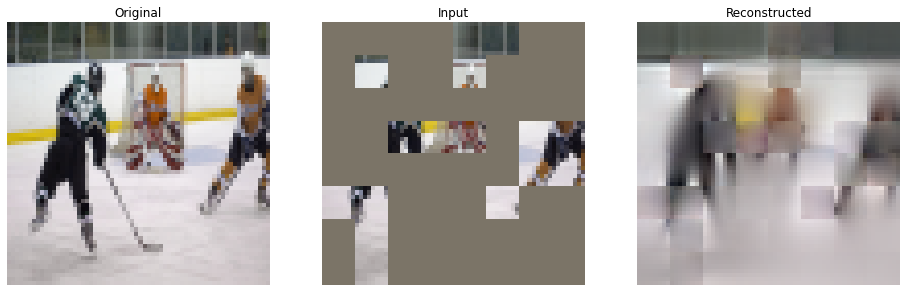

Averaged stats: lr: 0.000035  loss: 0.3141 (0.3154)
Evaluating on test data...


100%|██████████| 391/391 [00:39<00:00,  9.83it/s]

Evaluation loss (rgb) :  0.39569477352035015 

log_dir: /content/drive/MyDrive/ENS/Baby_mae


Epoch: [86]  [   0/2503]  eta: 2:31:55  lr: 0.000030  loss: 0.3109 (0.3109)  time: 3.6417  data: 3.2645  max mem: 12012
Epoch: [86]  [  20/2503]  eta: 0:35:13  lr: 0.000030  loss: 0.3150 (0.3147)  time: 0.7117  data: 0.3506  max mem: 12012
Epoch: [86]  [  40/2503]  eta: 0:32:17  lr: 0.000030  loss: 0.3100 (0.3140)  time: 0.7187  data: 0.3590  max mem: 12012
Epoch: [86]  [  60/2503]  eta: 0:30:43  lr: 0.000030  loss: 0.3146 (0.3151)  time: 0.6890  data: 0.3277  max mem: 12012
Epoch: [86]  [  80/2503]  eta: 0:29:44  lr: 0.000030  loss: 0.3162 (0.3155)  time: 0.6817  data: 0.3212  max mem: 12012
Epoch: [86]  [ 100/2503]  eta: 0:28:57  lr: 0.000030  loss: 0.3149 (0.3156)  time: 0.6674  data: 0.3074  max mem: 12012
Epoch: [86]  [ 120/2503]  eta: 0:28:39  lr: 0.000030  loss: 0.3181 (0.3157)  time: 0.7142  data: 0.3530  max mem: 12012
Epoch: [86]  [ 140/2503]  eta: 0:28:11  lr: 0.000030  loss: 0.3189 (0.3162)  time: 0.6825  data: 0.3223  max mem: 12012
Epoch: [86]  [ 160/2503]  eta: 0:27:48  

100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


Evaluation loss (rgb) :  0.39598456436715773 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [87]  [   0/2503]  eta: 2:26:51  lr: 0.000026  loss: 0.3233 (0.3233)  time: 3.5202  data: 3.1441  max mem: 12012
Epoch: [87]  [  20/2503]  eta: 0:33:39  lr: 0.000026  loss: 0.3156 (0.3146)  time: 0.6779  data: 0.3175  max mem: 12012
Epoch: [87]  [  40/2503]  eta: 0:30:54  lr: 0.000026  loss: 0.3181 (0.3157)  time: 0.6898  data: 0.3298  max mem: 12012
Epoch: [87]  [  60/2503]  eta: 0:29:42  lr: 0.000026  loss: 0.3146 (0.3146)  time: 0.6820  data: 0.3222  max mem: 12012
Epoch: [87]  [  80/2503]  eta: 0:28:58  lr: 0.000026  loss: 0.3113 (0.3147)  time: 0.6803  data: 0.3199  max mem: 12012
Epoch: [87]  [ 100/2503]  eta: 0:28:27  lr: 0.000026  loss: 0.3138 (0.3147)  time: 0.6829  data: 0.3226  max mem: 12012
Epoch: [87]  [ 120/2503]  eta: 0:27:58  lr: 0.000026  loss: 0.3088 (0.3142)  time: 0.6732  data: 0.3127  max mem: 12012
Epoch: [87]  [ 140/2503]  eta: 0:27:38  lr: 0.000026  loss: 0.3169 (

100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


Evaluation loss (rgb) :  0.39501291048496273 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [88]  [   0/2503]  eta: 2:28:19  lr: 0.000022  loss: 0.3125 (0.3125)  time: 3.5554  data: 3.1829  max mem: 12012
Epoch: [88]  [  20/2503]  eta: 0:34:26  lr: 0.000022  loss: 0.3168 (0.3169)  time: 0.6962  data: 0.3366  max mem: 12012
Epoch: [88]  [  40/2503]  eta: 0:31:13  lr: 0.000022  loss: 0.3127 (0.3151)  time: 0.6856  data: 0.3260  max mem: 12012
Epoch: [88]  [  60/2503]  eta: 0:29:48  lr: 0.000022  loss: 0.3121 (0.3146)  time: 0.6733  data: 0.3132  max mem: 12012
Epoch: [88]  [  80/2503]  eta: 0:28:59  lr: 0.000022  loss: 0.3159 (0.3146)  time: 0.6746  data: 0.3145  max mem: 12012
Epoch: [88]  [ 100/2503]  eta: 0:28:24  lr: 0.000022  loss: 0.3127 (0.3143)  time: 0.6744  data: 0.3144  max mem: 12012
Epoch: [88]  [ 120/2503]  eta: 0:27:52  lr: 0.000022  loss: 0.3173 (0.3147)  time: 0.6632  data: 0.3031  max mem: 12012
Epoch: [88]  [ 140/2503]  eta: 0:27:30  lr: 0.000022  loss: 0.3158 (

100%|██████████| 391/391 [00:38<00:00, 10.27it/s]


Evaluation loss (rgb) :  0.3956833946735353 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [89]  [   0/2503]  eta: 2:27:07  lr: 0.000019  loss: 0.3063 (0.3063)  time: 3.5267  data: 3.1416  max mem: 12012
Epoch: [89]  [  20/2503]  eta: 0:33:30  lr: 0.000019  loss: 0.3157 (0.3159)  time: 0.6740  data: 0.3135  max mem: 12012
Epoch: [89]  [  40/2503]  eta: 0:30:14  lr: 0.000019  loss: 0.3196 (0.3172)  time: 0.6603  data: 0.3005  max mem: 12012
Epoch: [89]  [  60/2503]  eta: 0:29:05  lr: 0.000019  loss: 0.3142 (0.3164)  time: 0.6688  data: 0.3085  max mem: 12012
Epoch: [89]  [  80/2503]  eta: 0:28:25  lr: 0.000019  loss: 0.3125 (0.3161)  time: 0.6717  data: 0.3111  max mem: 12012
Epoch: [89]  [ 100/2503]  eta: 0:28:00  lr: 0.000019  loss: 0.3140 (0.3159)  time: 0.6797  data: 0.3189  max mem: 12012
Epoch: [89]  [ 120/2503]  eta: 0:27:37  lr: 0.000019  loss: 0.3147 (0.3160)  time: 0.6785  data: 0.3186  max mem: 12012
Epoch: [89]  [ 140/2503]  eta: 0:27:28  lr: 0.000019  loss: 0.3141 (0

100%|██████████| 391/391 [00:38<00:00, 10.11it/s]


Evaluation loss (rgb) :  0.39474489286427605 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [90]  [   0/2503]  eta: 2:28:07  lr: 0.000016  loss: 0.3004 (0.3004)  time: 3.5508  data: 3.1703  max mem: 12012
Epoch: [90]  [  20/2503]  eta: 0:33:19  lr: 0.000016  loss: 0.3097 (0.3108)  time: 0.6681  data: 0.3082  max mem: 12012
Epoch: [90]  [  40/2503]  eta: 0:30:20  lr: 0.000016  loss: 0.3121 (0.3123)  time: 0.6696  data: 0.3091  max mem: 12012
Epoch: [90]  [  60/2503]  eta: 0:29:09  lr: 0.000016  loss: 0.3101 (0.3121)  time: 0.6691  data: 0.3087  max mem: 12012
Epoch: [90]  [  80/2503]  eta: 0:28:31  lr: 0.000016  loss: 0.3098 (0.3123)  time: 0.6766  data: 0.3169  max mem: 12012
Epoch: [90]  [ 100/2503]  eta: 0:28:06  lr: 0.000016  loss: 0.3148 (0.3129)  time: 0.6844  data: 0.3240  max mem: 12012
Epoch: [90]  [ 120/2503]  eta: 0:27:47  lr: 0.000016  loss: 0.3075 (0.3124)  time: 0.6892  data: 0.3280  max mem: 12012
Epoch: [90]  [ 140/2503]  eta: 0:27:29  lr: 0.000016  loss: 0.3126 (

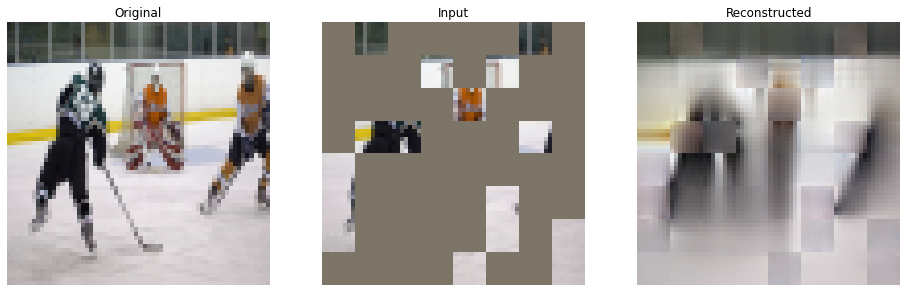

Averaged stats: lr: 0.000016  loss: 0.3149 (0.3134)
Evaluating on test data...


100%|██████████| 391/391 [00:38<00:00, 10.08it/s]

Evaluation loss (rgb) :  0.3943030390593097 

log_dir: /content/drive/MyDrive/ENS/Baby_mae


Epoch: [91]  [   0/2503]  eta: 2:28:51  lr: 0.000013  loss: 0.3188 (0.3188)  time: 3.5683  data: 3.1939  max mem: 12012
Epoch: [91]  [  20/2503]  eta: 0:35:09  lr: 0.000013  loss: 0.3166 (0.3181)  time: 0.7136  data: 0.3531  max mem: 12012
Epoch: [91]  [  40/2503]  eta: 0:31:16  lr: 0.000013  loss: 0.3147 (0.3162)  time: 0.6697  data: 0.3093  max mem: 12012
Epoch: [91]  [  60/2503]  eta: 0:29:52  lr: 0.000013  loss: 0.3114 (0.3149)  time: 0.6759  data: 0.3153  max mem: 12012
Epoch: [91]  [  80/2503]  eta: 0:29:09  lr: 0.000013  loss: 0.3111 (0.3147)  time: 0.6867  data: 0.3265  max mem: 12012
Epoch: [91]  [ 100/2503]  eta: 0:28:35  lr: 0.000013  loss: 0.3100 (0.3144)  time: 0.6808  data: 0.3210  max mem: 12012
Epoch: [91]  [ 120/2503]  eta: 0:28:14  lr: 0.000013  loss: 0.3123 (0.3142)  time: 0.6975  data: 0.3382  max mem: 12012
Epoch: [91]  [ 140/2503]  eta: 0:27:48  lr: 0.000013  loss: 0.3150 (0.3141)  time: 0.6752  data: 0.3148  max mem: 12012
Epoch: [91]  [ 160/2503]  eta: 0:27:29  

100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


Evaluation loss (rgb) :  0.3936013451317692 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [92]  [   0/2503]  eta: 2:22:36  lr: 0.000010  loss: 0.3080 (0.3080)  time: 3.4185  data: 3.0381  max mem: 12012
Epoch: [92]  [  20/2503]  eta: 0:33:04  lr: 0.000010  loss: 0.3179 (0.3162)  time: 0.6684  data: 0.3074  max mem: 12012
Epoch: [92]  [  40/2503]  eta: 0:30:40  lr: 0.000010  loss: 0.3126 (0.3156)  time: 0.6927  data: 0.3325  max mem: 12012
Epoch: [92]  [  60/2503]  eta: 0:29:43  lr: 0.000010  loss: 0.3140 (0.3151)  time: 0.6946  data: 0.3351  max mem: 12012
Epoch: [92]  [  80/2503]  eta: 0:29:13  lr: 0.000010  loss: 0.3186 (0.3155)  time: 0.7051  data: 0.3454  max mem: 12012
Epoch: [92]  [ 100/2503]  eta: 0:28:48  lr: 0.000010  loss: 0.3151 (0.3150)  time: 0.7008  data: 0.3406  max mem: 12012
Epoch: [92]  [ 120/2503]  eta: 0:28:27  lr: 0.000010  loss: 0.3086 (0.3144)  time: 0.7020  data: 0.3416  max mem: 12012
Epoch: [92]  [ 140/2503]  eta: 0:28:02  lr: 0.000010  loss: 0.3115 (0

100%|██████████| 391/391 [00:38<00:00, 10.09it/s]


Evaluation loss (rgb) :  0.3946242410965893 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [93]  [   0/2503]  eta: 2:21:29  lr: 0.000008  loss: 0.3180 (0.3180)  time: 3.3917  data: 3.0122  max mem: 12012
Epoch: [93]  [  20/2503]  eta: 0:33:17  lr: 0.000008  loss: 0.3106 (0.3107)  time: 0.6749  data: 0.3145  max mem: 12012
Epoch: [93]  [  40/2503]  eta: 0:30:07  lr: 0.000008  loss: 0.3112 (0.3114)  time: 0.6600  data: 0.2984  max mem: 12012
Epoch: [93]  [  60/2503]  eta: 0:29:03  lr: 0.000008  loss: 0.3139 (0.3122)  time: 0.6721  data: 0.3109  max mem: 12012
Epoch: [93]  [  80/2503]  eta: 0:28:29  lr: 0.000008  loss: 0.3082 (0.3119)  time: 0.6809  data: 0.3210  max mem: 12012
Epoch: [93]  [ 100/2503]  eta: 0:28:05  lr: 0.000008  loss: 0.3159 (0.3128)  time: 0.6843  data: 0.3241  max mem: 12012
Epoch: [93]  [ 120/2503]  eta: 0:27:45  lr: 0.000008  loss: 0.3106 (0.3125)  time: 0.6861  data: 0.3259  max mem: 12012
Epoch: [93]  [ 140/2503]  eta: 0:27:27  lr: 0.000008  loss: 0.3116 (0

100%|██████████| 391/391 [00:38<00:00, 10.17it/s]


Evaluation loss (rgb) :  0.39444963729290095 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [94]  [   0/2503]  eta: 2:25:25  lr: 0.000006  loss: 0.3022 (0.3022)  time: 3.4859  data: 3.1069  max mem: 12012
Epoch: [94]  [  20/2503]  eta: 0:33:03  lr: 0.000006  loss: 0.3155 (0.3161)  time: 0.6645  data: 0.3030  max mem: 12012
Epoch: [94]  [  40/2503]  eta: 0:30:16  lr: 0.000006  loss: 0.3164 (0.3156)  time: 0.6734  data: 0.3131  max mem: 12012
Epoch: [94]  [  60/2503]  eta: 0:29:48  lr: 0.000006  loss: 0.3120 (0.3149)  time: 0.7206  data: 0.3600  max mem: 12012
Epoch: [94]  [  80/2503]  eta: 0:29:00  lr: 0.000006  loss: 0.3133 (0.3144)  time: 0.6756  data: 0.3143  max mem: 12012
Epoch: [94]  [ 100/2503]  eta: 0:28:22  lr: 0.000006  loss: 0.3119 (0.3143)  time: 0.6703  data: 0.3091  max mem: 12012
Epoch: [94]  [ 120/2503]  eta: 0:27:54  lr: 0.000006  loss: 0.3093 (0.3137)  time: 0.6734  data: 0.3125  max mem: 12012
Epoch: [94]  [ 140/2503]  eta: 0:27:32  lr: 0.000006  loss: 0.3109 (

100%|██████████| 391/391 [00:37<00:00, 10.37it/s]


Evaluation loss (rgb) :  0.39482997415010884 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [95]  [   0/2503]  eta: 2:24:18  lr: 0.000004  loss: 0.3260 (0.3260)  time: 3.4592  data: 3.0863  max mem: 12012
Epoch: [95]  [  20/2503]  eta: 0:33:13  lr: 0.000004  loss: 0.3099 (0.3143)  time: 0.6699  data: 0.3090  max mem: 12012
Epoch: [95]  [  40/2503]  eta: 0:30:04  lr: 0.000004  loss: 0.3122 (0.3127)  time: 0.6589  data: 0.2975  max mem: 12012
Epoch: [95]  [  60/2503]  eta: 0:28:58  lr: 0.000004  loss: 0.3106 (0.3126)  time: 0.6682  data: 0.3073  max mem: 12012
Epoch: [95]  [  80/2503]  eta: 0:28:09  lr: 0.000004  loss: 0.3109 (0.3129)  time: 0.6542  data: 0.2933  max mem: 12012
Epoch: [95]  [ 100/2503]  eta: 0:27:39  lr: 0.000004  loss: 0.3156 (0.3133)  time: 0.6637  data: 0.3035  max mem: 12012
Epoch: [95]  [ 120/2503]  eta: 0:27:16  lr: 0.000004  loss: 0.3099 (0.3126)  time: 0.6660  data: 0.3054  max mem: 12012
Epoch: [95]  [ 140/2503]  eta: 0:26:54  lr: 0.000004  loss: 0.3111 (

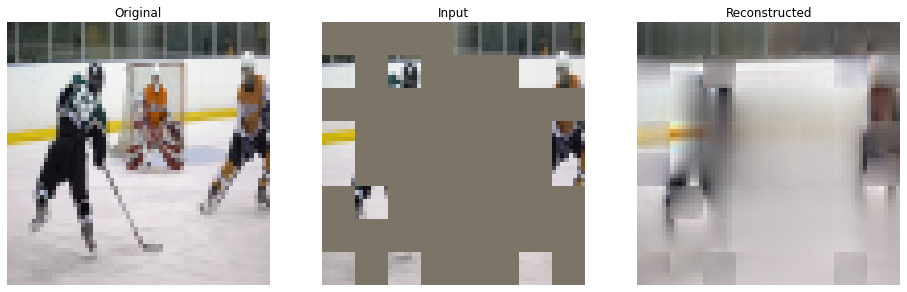

Averaged stats: lr: 0.000004  loss: 0.3109 (0.3122)
Evaluating on test data...


100%|██████████| 391/391 [00:38<00:00, 10.27it/s]

Evaluation loss (rgb) :  0.3945289658920844 

log_dir: /content/drive/MyDrive/ENS/Baby_mae


Epoch: [96]  [   0/2503]  eta: 2:24:25  lr: 0.000003  loss: 0.3265 (0.3265)  time: 3.4622  data: 3.0920  max mem: 12012
Epoch: [96]  [  20/2503]  eta: 0:34:22  lr: 0.000003  loss: 0.3148 (0.3171)  time: 0.6991  data: 0.3378  max mem: 12012
Epoch: [96]  [  40/2503]  eta: 0:30:59  lr: 0.000003  loss: 0.3166 (0.3179)  time: 0.6756  data: 0.3147  max mem: 12012
Epoch: [96]  [  60/2503]  eta: 0:29:35  lr: 0.000003  loss: 0.3167 (0.3177)  time: 0.6690  data: 0.3073  max mem: 12012
Epoch: [96]  [  80/2503]  eta: 0:28:46  lr: 0.000003  loss: 0.3134 (0.3176)  time: 0.6683  data: 0.3070  max mem: 12012
Epoch: [96]  [ 100/2503]  eta: 0:28:13  lr: 0.000003  loss: 0.3138 (0.3173)  time: 0.6740  data: 0.3141  max mem: 12012
Epoch: [96]  [ 120/2503]  eta: 0:27:49  lr: 0.000003  loss: 0.3169 (0.3175)  time: 0.6792  data: 0.3190  max mem: 12012
Epoch: [96]  [ 140/2503]  eta: 0:27:25  lr: 0.000003  loss: 0.3171 (0.3176)  time: 0.6709  data: 0.3103  max mem: 12012
Epoch: [96]  [ 160/2503]  eta: 0:27:06  

100%|██████████| 391/391 [00:39<00:00, 10.02it/s]


Evaluation loss (rgb) :  0.3938447887940175 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [97]  [   0/2503]  eta: 2:37:07  lr: 0.000001  loss: 0.3164 (0.3164)  time: 3.7663  data: 3.3889  max mem: 12012
Epoch: [97]  [  20/2503]  eta: 0:34:22  lr: 0.000001  loss: 0.3176 (0.3179)  time: 0.6838  data: 0.3224  max mem: 12012
Epoch: [97]  [  40/2503]  eta: 0:31:18  lr: 0.000001  loss: 0.3176 (0.3184)  time: 0.6913  data: 0.3294  max mem: 12012
Epoch: [97]  [  60/2503]  eta: 0:29:51  lr: 0.000001  loss: 0.3128 (0.3161)  time: 0.6729  data: 0.3110  max mem: 12012
Epoch: [97]  [  80/2503]  eta: 0:29:06  lr: 0.000001  loss: 0.3130 (0.3158)  time: 0.6821  data: 0.3209  max mem: 12012
Epoch: [97]  [ 100/2503]  eta: 0:28:28  lr: 0.000001  loss: 0.3161 (0.3155)  time: 0.6719  data: 0.3113  max mem: 12012
Epoch: [97]  [ 120/2503]  eta: 0:28:04  lr: 0.000001  loss: 0.3155 (0.3154)  time: 0.6869  data: 0.3252  max mem: 12012
Epoch: [97]  [ 140/2503]  eta: 0:27:41  lr: 0.000001  loss: 0.3148 (0

100%|██████████| 391/391 [00:38<00:00, 10.29it/s]


Evaluation loss (rgb) :  0.3927439649391662 

log_dir: /content/drive/MyDrive/ENS/Baby_mae
Epoch: [98]  [   0/2503]  eta: 2:23:33  lr: 0.000001  loss: 0.3176 (0.3176)  time: 3.4414  data: 3.0711  max mem: 12012
Epoch: [98]  [  20/2503]  eta: 0:33:15  lr: 0.000001  loss: 0.3154 (0.3189)  time: 0.6716  data: 0.3109  max mem: 12012
Epoch: [98]  [  40/2503]  eta: 0:30:33  lr: 0.000001  loss: 0.3148 (0.3183)  time: 0.6826  data: 0.3222  max mem: 12012
Epoch: [98]  [  60/2503]  eta: 0:29:17  lr: 0.000001  loss: 0.3177 (0.3174)  time: 0.6673  data: 0.3060  max mem: 12012
Epoch: [98]  [  80/2503]  eta: 0:28:42  lr: 0.000001  loss: 0.3127 (0.3167)  time: 0.6850  data: 0.3239  max mem: 12012
Epoch: [98]  [ 100/2503]  eta: 0:28:19  lr: 0.000001  loss: 0.3171 (0.3169)  time: 0.6922  data: 0.3301  max mem: 12012
Epoch: [98]  [ 120/2503]  eta: 0:27:58  lr: 0.000001  loss: 0.3140 (0.3165)  time: 0.6910  data: 0.3298  max mem: 12012
Epoch: [98]  [ 140/2503]  eta: 0:27:37  lr: 0.000001  loss: 0.3169 (0

In [ ]:
print(f"Start training for {epochs} epochs")
start_time = time.time()
for epoch in range(start_epoch, epochs):
    train_stats = train_one_epoch(
        model, inet_train_loader,
        optimizer, device, epoch, loss_scaler,
        log_writer=log_writer,
        lr = lr,
        min_lr = min_lr,
        epochs = epochs,
        warmup_epochs = warmup_epochs,
        accum_iter = accum_iter,
        mask_ratio = mask_ratio,
        scheduler = scheduler,
        ref=img_test
    )
    if output_dir and (epoch % 5 == 0 or epoch + 1 == epochs): #save
        save_model(
            model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
            loss_scaler=loss_scaler, epoch=epoch,output_dir = output_dir,scheduler = scheduler)
        #p = 'checkpoint-'+str(epoch)+'.pth'
        #!cp $p '/content/drive/MyDrive/ENS/'

        #---------------------
    print('Evaluating on test data...')
    eval_loss_rgb = evaluate(model,inet_val_loader,mask_ratio=mask_ratio)
    print('Evaluation loss (rgb) : ',eval_loss_rgb,'\n')

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch,'eval_loss_rgb' : eval_loss_rgb}


    if output_dir and is_main_process():
        if log_writer is not None:
            log_writer.flush()
        with open(os.path.join(output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
            f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))